In [154]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import nltk

from sklearn.naive_bayes import MultinomialNB

from nltk.corpus import stopwords
import re

import joblib

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout




nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\Cristopher
[nltk_data]     Artacho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [155]:
# Load dataset
df = pd.read_csv("sentiment_analysis.csv") 

In [156]:
# Keep only relevant columns
df = df[["text", "sentiment"]]

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       499 non-null    object
 1   sentiment  499 non-null    object
dtypes: object(2)
memory usage: 7.9+ KB


In [158]:
for col in df:
    print(df[col].nunique())

394
3


In [159]:
df['sentiment'].value_counts()

sentiment
neutral     199
positive    166
negative    134
Name: count, dtype: int64

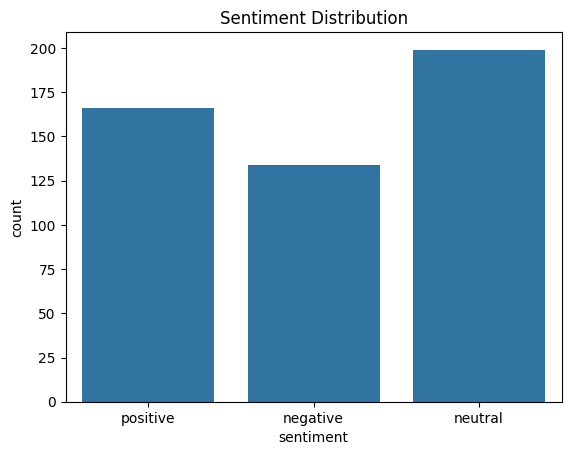

In [ ]:
sns.countplot(x=df["sentiment"])
plt.title("Sentiment Distribution")
plt.show()
plt.close() 

In [161]:
def clean_text(text):
    text = text.lower() 
    text = re.sub(r'[^a-zA-Z\s]', '', text)  
    text = ' '.join([word for word in text.split() if word not in stop_words]) 
    return text


In [162]:
df["Cleaned_Text"] = df["text"].apply(clean_text)

In [163]:

sentiment_mapping = {"neutral": 0, "positive": 1,  "negative": 2}
df["sentiment"] = df["sentiment"].map(sentiment_mapping)

In [164]:
X_train, X_test, y_train, y_test = train_test_split(df["Cleaned_Text"], df["sentiment"], test_size=0.1, random_state=42)


In [165]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [166]:
# Train Naïve Bayes Model
MNBmodel = MultinomialNB()
MNBmodel.fit(X_train_tfidf, y_train)

MultinomialNB()

In [167]:
# Predictions
MNBy_pred = MNBmodel.predict(X_test_tfidf)

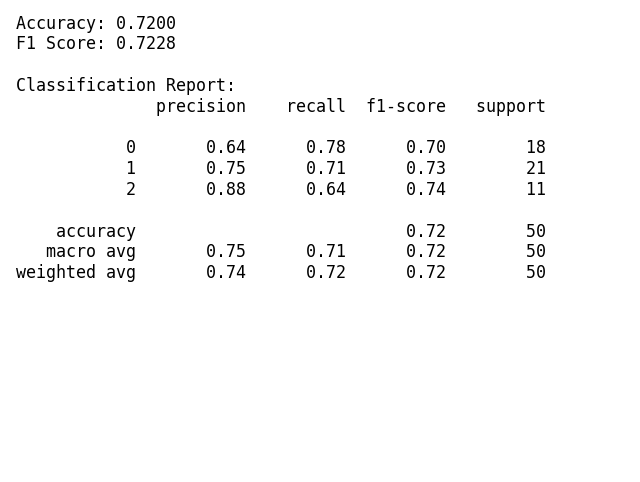

In [ ]:
# MULTINOMIAL NAIVE BAYES MODEL EVALUATION
MNBaccuracy = accuracy_score(y_test, MNBy_pred)
MNBf1 = f1_score(y_test, MNBy_pred, average="macro")
MNBreport = classification_report(y_test, MNBy_pred)

text_output = f"Accuracy: {MNBaccuracy:.4f}\nF1 Score: {MNBf1:.4f}\n\nClassification Report:\n{MNBreport}"

plt.figure(figsize=(8, 6))
plt.text(0.01, 0.99, text_output, fontsize=12, ha='left', va='top', family="monospace")
plt.axis("off")
plt.show()

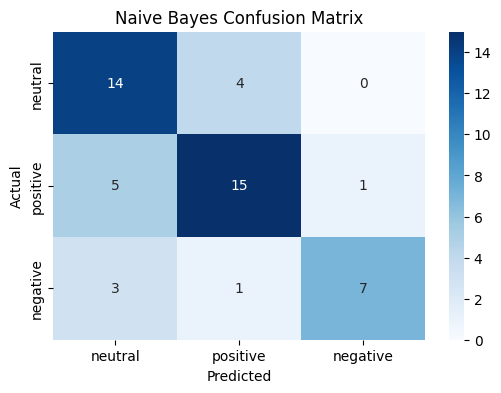

In [ ]:
conf_matrix = confusion_matrix(y_test, MNBy_pred)
# Confusion Matrix Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=sentiment_mapping.keys(), yticklabels=sentiment_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Naive Bayes Confusion Matrix")
plt.show()

In [ ]:
vocab_size = 5000
embedding_dim = 64
max_length = 100
num_classes = 3

In [171]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

In [ ]:
X_train_sequential = tokenizer.texts_to_sequences(X_train)
X_test_sequential = tokenizer.texts_to_sequences(X_test)

In [ ]:
X_train_pad = pad_sequences(X_train_sequential, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_sequential, maxlen=max_length, padding='post')

In [ ]:
encoder = LabelEncoder()
y_train_encoder = encoder.fit_transform(y_train)
y_test_encoder = encoder.transform(y_test)

In [ ]:
y_train_cat = to_categorical(y_train_encoder, num_classes=num_classes)
y_test_cat = to_categorical(y_test_encoder, num_classes=num_classes)

In [176]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

C:\Users\Cristopher Artacho\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [177]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_pad, y_train_cat,
                    validation_data=(X_test_pad, y_test_cat),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.3896 - loss: 1.0931 - val_accuracy: 0.3600 - val_loss: 1.0914
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3883 - loss: 1.0910 - val_accuracy: 0.3600 - val_loss: 1.0940
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3801 - loss: 1.0968 - val_accuracy: 0.3600 - val_loss: 1.0895
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4086 - loss: 1.0825 - val_accuracy: 0.3600 - val_loss: 1.0836
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3431 - loss: 1.1065 - val_accuracy: 0.3600 - val_loss: 1.0843
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4066 - loss: 1.0913 - val_accuracy: 0.3600 - val_loss: 1.0829
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4054 - loss: 1.0910 - val_accuracy: 0.3600 - val_loss: 1.0912
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3480 - loss: 1.1026 - val_accuracy: 0.3600 - v

In [ ]:
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)
target_names = [str(c) for c in encoder.classes_]
print(classification_report(y_test_encoder, y_pred_classes, target_names=target_names))

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002686E12DDA0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
              precision    recall  f1-score   support

           0       0.36      1.00      0.53        18
           1       0.00      0.00      0.00        21
           2       0.00      0.00 

C:\Users\Cristopher Artacho\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Cristopher Artacho\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Cristopher Artacho\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control